In [1]:
%load_ext autotime

time: 285 µs (started: 2022-10-12 14:34:42 +00:00)


In [2]:
from google.cloud import bigquery

client = bigquery.Client()

time: 11.3 ms (started: 2022-10-12 14:34:43 +00:00)


In [3]:
# Query para obtener la data de 3 días antes, considerando que el enlace de la foto, 
# el nombre del transportista y su rut, no sean nulos

sql = """
SELECT DISTINCT transport_ord_id as SOC, i.url as url, shipment.plate_num as plate_num, 
provider.doc_id as provider_id, 
provider.doc_verify_digit as provider_verify_digit,
provider.name as provider_name, driver.doc_id as driver_id, 
driver.doc_verify_digit as driver_verify_digit,
driver.name as driver_name, driver.last_name as driver_last_name,
DATETIME(event_crte_tmst, 'America/Santiago') as event_crte_tmst, dfl_crte_tmst
FROM 
`tc-sc-bi-bigdata-corp-tsod-dev.image_recognition.btd_scha_fal_trmg_api_transport_order_temp`,
unnest(image) as i
 
WHERE
  i.url is not null
  and provider.name is not null
  and provider.doc_id is not null
  and DATE(event_crte_tmst, 'America/Santiago') = current_date() - 6

"""

df_images = client.query(sql).to_dataframe()

print(len(df_images))

241328
time: 5.67 s (started: 2022-10-12 14:34:43 +00:00)


In [4]:
# eliminar filas con urls duplicados
df_images = df_images.drop_duplicates(['url'])
# resetear indices
df_images = df_images.reset_index()
# eliminar columna index
df_images = df_images.drop(['index'], axis = 1)
print(len(df_images))

240888
time: 195 ms (started: 2022-10-12 14:34:49 +00:00)


Pruebas para leer enlaces mas rapido

In [5]:
import requests
import time
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool

time: 3.94 ms (started: 2022-10-12 14:34:49 +00:00)


In [6]:
inputs_df = df_images.iloc[0:100].url
inputs_list = df_images.iloc[0:10].url.to_list()
inputs_array = df_images.iloc[0:10].url.to_numpy()

time: 1.87 ms (started: 2022-10-12 14:34:50 +00:00)


In [103]:
from google.cloud import storage
import cv2
from tempfile import TemporaryFile
import numpy as np
client = storage.Client()
bucket = client.get_bucket('image_recognition_images')
blobs = client.list_blobs(bucket)
blob_list = list(blobs)

time: 159 ms (started: 2022-10-12 15:02:49 +00:00)


In [104]:
urls = []
for blob in blob_list:
    url = 'https://prdadessacorptrl.blob.core.windows.net/cl-images/' + blob.name
    urls.append(url)

time: 964 µs (started: 2022-10-12 15:02:51 +00:00)


In [105]:
from google.cloud import storage
import cv2
from tempfile import TemporaryFile
import numpy as np


# función para leer imágenes desde el bucket
def read_image_bucket(blob_object):
    filename = blob_object.name
    client = storage.Client()
    
    bucket = client.get_bucket('image_recognition_images')
    blob = bucket.get_blob(filename)
    
    b = blob.download_as_bytes()
    image_cv = np.asarray(bytearray(b), dtype="uint8")
    image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    area = image.shape[0]*image.shape[1]
    #print(image.shape)
    #print(area)
    
    return(image, area)

time: 1.72 ms (started: 2022-10-12 15:02:52 +00:00)


In [106]:
import urllib
import urllib.request
import cv2
# funcion para abrir url y guardar area
def open_url_wa(args):
    url = args
    try:
        url_open = urllib.request.urlopen(url)
        image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
        image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        area = image.shape[0]*image.shape[1]
        #print(area)
        return(image, area)
    except:
        pass

time: 866 µs (started: 2022-10-12 15:02:55 +00:00)


In [32]:
#t0 = time.time()
lista_base_0 = []
#for i in inputs_df:
for i in urls[:10]:
    result = open_url_wa(i)
    lista_base_0.append(result)
    #print('url:', result[0], 'time:', result[1])
#print('Total time:', time.time() - t0)

https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005210008-Falabella-149076171403-1-EVIDENCE.png
(250, 187, 3)
46750
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005210106-Falabella-149076599043-1-EVIDENCE.png
(252, 113, 3)
28476
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005210727-Falabella-149076012655-1-EVIDENCE.png
(192, 144, 3)
27648
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005210919-Falabella-149076136782-1-EVIDENCE.png
(250, 187, 3)
46750
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005211330-Falabella-149076101700-1-EVIDENCE.png
(204, 92, 3)
18768
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005211428-Falabella-149077402485-2-EVIDENCE.png
(640, 480, 3)
307200
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005212243-Falabella-149076403752-1-EVIDENCE.png
(204, 153, 3)
31212
https://prdadessacorptrl.blob.core.windows.net/cl-images/20221005212330-Falabella-14907614

In [302]:
import numpy as np
empty_array = np.empty([])

time: 586 µs (started: 2022-10-11 18:16:40 +00:00)


In [107]:
# funcion para trabajar en paralelo
def open_parallel_url(args):
    cpus = cpu_count()
    results = ThreadPool(cpus - 1).imap_unordered(open_url_wa, args)
    import numpy as np
    lista_base = []
    for result in results:
        lista_base.append(result)
    return(lista_base)

time: 594 µs (started: 2022-10-12 15:02:59 +00:00)


In [108]:
# funcion para trabajar en paralelo
def open_parallel_bucket(args):
    cpus = cpu_count()
    results = ThreadPool(cpus - 1).imap_unordered(read_image_bucket, args)
    import numpy as np
    lista_base = []
    for result in results:
        lista_base.append(result)
    return(lista_base)

time: 629 µs (started: 2022-10-12 15:03:00 +00:00)


In [109]:
l_url  = open_parallel_url(urls[:200])

time: 24.4 s (started: 2022-10-12 15:03:03 +00:00)


In [110]:
l_bucket = open_parallel_bucket(blob_list[:200])

time: 8.08 s (started: 2022-10-12 15:03:28 +00:00)


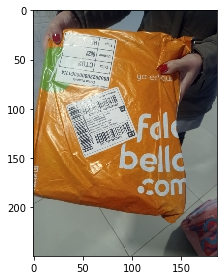

time: 119 ms (started: 2022-10-12 15:02:35 +00:00)


In [102]:
from skimage import io
io.imshow(l_url[0][0])

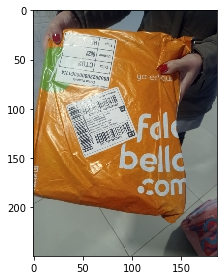

time: 116 ms (started: 2022-10-12 15:02:31 +00:00)


In [101]:
from skimage import io
io.imshow(l_bucket[1][0])

In [305]:
# Dataset class

class PredictionDataset(Dataset):
    """Photos prediction dataset."""

    def __init__(self, lista_fotos, normalization = 'mlc', device = 'cuda'):
        """
        Args:
            lista_fotos (list): Lista con varias fotos concatenadas y sus areas
            normalization (string): Indica si se debe implementar la transformación
            de normalización para el clasificador multi-etiqueta ('mlc') o para el 
            detector de objetos ('ob')
            device (string): Indica qué dispositivo se quiere usar: 'cuda' o 'cpu'
        
        Returns:
            pro_img (tensor): Retorna la imagen procesada como tensor lista para la predicción.
        """
        self.lista_fotos = lista_fotos
        self.normalization = normalization
        self.device = device
        # transformación para clasificador
        self.mlc_normalization = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
    
    def __len__(self):
        return len(self.lista_fotos)

    def __getitem__(self, idx):
        foto = self.lista_fotos[idx][0]
        area = self.lista_fotos[idx][1]
        # aplicar normalizacion
        if self.normalization == 'mlc':
            pro_img  = self.mlc_normalization(foto)
            #print(t_img.shape)
            #pro_img = t_img.unsqueeze(dim = 0)
            #print(pro_img.shape)
        
        elif self.normalization == 'od':
            t_img_0 = transform.resize(foto, (480, 480))
            pro_img = torch.Tensor(t_img_0).permute(2,0,1)

        # retornar imagen procesada
        return pro_img, area

time: 2.23 ms (started: 2022-10-11 18:16:47 +00:00)


In [306]:
prediction_set_mlc = PredictionDataset(lista_fotos = l, normalization = 'mlc', device = 'cuda')
prediction_set_od = PredictionDataset(lista_fotos = l, normalization = 'od', device = 'cuda')

predictionLoader_mlc = DataLoader(prediction_set_mlc, batch_size=32, num_workers=2,
                         shuffle = False)
predictionLoader_od = DataLoader(prediction_set_od, batch_size=32, num_workers=2,
                         shuffle = False)

time: 1.74 ms (started: 2022-10-11 18:16:49 +00:00)


In [307]:
def bbox_function(b, area_img):
    l =list(range(b.shape[0]))
    # recorrer cajas y calcular inter-area para cada combinación
    indice = 0
    interArea = 0
    for i in itertools.combinations(l, r=2):
        # obtener coordenadas de la inter-area
        x0 = max(b[i[0]][0], b[i[1]][0])
        y0 = max(b[i[0]][1], b[i[1]][1])
        x1 = min(b[i[0]][2], b[i[1]][2])
        y1 = min(b[i[0]][3], b[i[1]][3])

        # calcular inter-area
        dif_x = x0-x1
        dif_y = y0-y1
        # se verifica que las esquinas de la interArea esten bien ubicadas 
        if dif_x < 0 and dif_y < 0:
            interArea += dif_x*dif_y
            ##interArea += abs(x0-x1)*abs(y0-y1)
    
    # sumar areas de cada bbox
    area_total_bbox = 0
    for box in b:
        # calcular area de cada bbox
        area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
        # calcular area total de bbox
        area_total_bbox += area_bbox

    # calcular la union de las areas de cada bbox
    union = area_total_bbox - interArea

    # calcular contexto
    if torch.is_tensor(union):
        contexto = union.item()/area_img
    
    else:
        contexto = union/area_img
    
    return contexto

time: 2.02 ms (started: 2022-10-11 18:16:53 +00:00)


In [189]:
ql = np.array([[154.09753, 138.35898, 289.87354, 453.7443 ],
       [ 72.7833 ,  28.08166, 306.60788, 471.55804],
       [171.26457, 138.85587, 304.7947 , 320.8897 ]])

time: 795 µs (started: 2022-10-11 15:31:17 +00:00)


In [190]:
ql.shape[0]

3

time: 2.44 ms (started: 2022-10-11 15:31:25 +00:00)


In [191]:
l = list(range(ql.shape[0]))
print(l)

[0, 1, 2]
time: 854 µs (started: 2022-10-11 15:31:34 +00:00)


In [187]:
import itertools
for i in itertools.combinations([0, 1,2], r=2):
    print(i)
    

(0, 1)
(0, 2)
(1, 2)
time: 608 µs (started: 2022-10-11 15:30:26 +00:00)


In [332]:
pesos = {'w_prod': 0.4, 'w_notface': 0.1,'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2}

thresholds = {'t_prod': 0.5, 't_face': 0.5, 't_label': 0.5, 't_num': 0.5, 't_ctx_down': 0.2, 
              't_ctx_up': 0.65}

device = 'cuda'
# evaluar con gpu o cpu 
device = torch.device(device)
classificator_1 = ml_model_1 
classificator_2 = ml_model_2
detector = od_model

classificator_1.to(device)
classificator_1.eval()  
classificator_2.to(device)
classificator_2.eval()           
detector.to(device)
detector.eval()
with torch.no_grad():
    for i, image in enumerate(zip(predictionLoader_mlc, predictionLoader_od)):
        # se obtiene la imagen de cada dataLoader
        image_mlc = image[0][0]
        image_od = image[1][0]
        
        area_img = image[0][1]

        # CLASIFICACION MULTI-ETIQUETA
        #---------------------------clasificador 1--------------------------------
        label_base = classificator_1(image_mlc.to(device))
        #---------------------------clasificador 2--------------------------------
        label_etiqueta = classificator_2(image_mlc.to(device))
        # obtener score
        score_etiqueta = torch.sigmoid(label_etiqueta['label']).squeeze()
        score = torch.sigmoid(label_base['label']).squeeze()
        ##print('score:',score.shape)
        # obtener predicción etiqueta
        s_etiqueta = score_etiqueta[:,0]
        etiqueta = torch.where(s_etiqueta >= thresholds['t_label'], 1, 0)
        # obtener predicción domicilio
        s_domicilio = score[:,1]
        domicilio = torch.where(s_domicilio >= thresholds['t_num'], 1, 0)
        # obtener predicción cara
        s_cara = score[:,2]
        s_no_cara = 1-s_cara
        no_cara = torch.where(s_no_cara >= thresholds['t_face'], 1, 0)
        
        etiqueta = etiqueta.reshape(-1,1).to('cpu').numpy()
        s_etiqueta = s_etiqueta.reshape(-1,1).to('cpu').numpy()
        domicilio = domicilio.reshape(-1,1).to('cpu').numpy()
        s_domicilio = s_domicilio.reshape(-1,1).to('cpu').numpy()
        no_cara = no_cara.reshape(-1,1).to('cpu').numpy()
        s_no_cara = s_no_cara.reshape(-1,1).to('cpu').numpy()
        
        #-----------------------------------------------------------------------------
        # DETECTOR DE OBJETOS
        od_prediction = od_model(image_od.to(device))
        ##print(od_prediction)
        dataFrame = pd.DataFrame(od_prediction).to_dict(orient="list")
        #print(dataFrame['boxes'])
        #print(torch.Tensor(dataFrame['boxes']))
        list_of_lists = list(map(lambda x: x.tolist(), dataFrame['boxes']))
        array_of_arrays1= np.array(list(map(lambda x: x.to('cpu').numpy(), dataFrame['boxes'])))
        array_of_arrays2= np.array(list(map(lambda x: x.to('cpu').numpy(), dataFrame['scores'])))
        #bla = list(map(lambda x: torch.where(x >= 0.5, 1, 0), dataFrame['scores']))
        bla2 = np.array(list(map(lambda x: np.where(x.to('cpu').numpy()>=thresholds['t_prod'],1,
                                                    0).reshape(-1,1),
                                 dataFrame['scores'])))
        #print(array_of_arrays1)
        #print(bla2)
        producto = array_of_arrays1*bla2
        #print(producto)
        producto_wz = np.array(list(map(lambda x: x[~np.all(x == 0, axis=1)], producto)))
        contexto = np.array(list(map(lambda x,y: bbox_function(x,y), producto_wz, area_img)))
        contexto = contexto.reshape(-1,1)
        ctx_value = np.where(((contexto >= thresholds['t_ctx_down']) & (contexto <= thresholds['t_ctx_up'])),
                             1, 0) 
        #print(ctx_value)
        #print(array_of_arrays*array_of_arrays)
        #print(array_of_arrays2)
        #print(np.where(array_of_arrays2.all() < 0.5, 0, array_of_arrays2))
        #print(list(map(lambda x: max(x), dataFrame['boxes'])))
        s_paquete = torch.tensor(list(map(lambda x: max(x, default=0), dataFrame['scores'])))
        s_paquete = s_paquete.reshape(-1,1)
        #printtorch.tensor(dataFrame['scores'])
        #print(scores.reshape(-1,1).to('cpu').numpy())
        paquete = torch.where(s_paquete >= thresholds['t_prod'], 1, 0)
        #############listos con score!!#################3
        # que pasa si no se puede leer el url?
        # que pasa si la imagen no tiene bbox? -> funciona todo bien
        # falta enlace: corecto o incorrecto
        
        result = np.concatenate([s_paquete, paquete, etiqueta, s_etiqueta, no_cara, s_no_cara,
                                domicilio, s_domicilio, contexto, ctx_value], axis = 1)
        
        ##print(result)
        df = pd.DataFrame(result, columns=['s_paquete','paquete','etiqueta_producto', \
                                                       's_etiqueta_producto', 'sin_rostro', 's_sin_rostro',\
                                                       'numero_domicilio', 's_numero_domicilio', 'contexto',\
                                                       'ctx_value'])
        
        pesos = {'w_prod': 0.4, 'w_notface': 0.1,'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2}
        df['score'] = df.paquete*pesos['w_prod'] + df.etiqueta_producto*pesos['w_label'] + \
        df.sin_rostro*pesos['w_notface'] + df.numero_domicilio*pesos['w_num'] + df.ctx_value*pesos['w_contx']
        #FALTA GUARDAR EL ENLACE Y NOTIFICAR CUANDO UN ENLACE ESTA ERRONEO

time: 2.17 s (started: 2022-10-11 18:43:39 +00:00)


In [333]:
print(df)

   s_paquete  paquete  etiqueta_producto  s_etiqueta_producto  sin_rostro  \
0   0.999650      1.0                1.0             1.000000         1.0   
1   0.999759      1.0                1.0             1.000000         1.0   
2   0.999215      1.0                1.0             1.000000         1.0   
3   0.997923      1.0                1.0             1.000000         1.0   
4   0.998864      1.0                1.0             1.000000         1.0   
5   0.999194      1.0                1.0             1.000000         1.0   
6   0.999730      1.0                1.0             1.000000         1.0   
7   0.999528      1.0                1.0             1.000000         1.0   
8   0.993000      1.0                1.0             1.000000         1.0   
9   0.000000      0.0                0.0             0.000453         1.0   

   s_sin_rostro  numero_domicilio  s_numero_domicilio  contexto  ctx_value  \
0      0.985684               0.0            0.041721  0.633455        1.0

In [120]:
a1 = np.array([[154.09753, 138.35898, 289.87354, 453.7443 ],
       [ 72.7833 ,  28.08166, 306.60788, 471.55804],
       [171.26457, 138.85587, 304.7947 , 320.8897 ]])
a2 = np.array([1,0,1])

time: 708 µs (started: 2022-10-11 14:33:42 +00:00)


In [145]:
a3 = a2.reshape(-1,1)

time: 389 µs (started: 2022-10-11 14:42:34 +00:00)


In [146]:
print(a3.shape)

(3, 1)
time: 479 µs (started: 2022-10-11 14:42:36 +00:00)


In [150]:
a4 = a1*a3

time: 457 µs (started: 2022-10-11 14:44:32 +00:00)


In [151]:
a4[~(a4==0).all(1)]

array([[154.09753, 138.35898, 289.87354, 453.7443 ],
       [171.26457, 138.85587, 304.7947 , 320.8897 ]])

time: 3.33 ms (started: 2022-10-11 14:44:39 +00:00)


In [ ]:
# analizar score para 'paquete'
        s_paquete = max(od_prediction[0]['scores']).item()
        if od_prediction[0]['labels'].shape[0] > 0 and \
        s_paquete >= thresholds['t_prod']:
          paquete = 1
        else:
          paquete = 0 
        # determinar unión de todos los bbox que encierren a un paquete (score >= t_prod) 
        boxes = od_prediction[0]['boxes'].to(device)
        scores = od_prediction[0]['scores'].to(device)
        scores = torch.where(scores >= thresholds['t_prod'], 1, 0)
        scores = torch.unsqueeze(scores, dim=0)
        scores_t = torch.transpose(scores, 0, 1)
        mult = torch.mul(boxes, scores_t)
        b = mult[mult.sum(dim=1) != 0] # eliminar filas con puros ceros
        l =list(range(b.size()[0]))
        # recorrer cajas y calcular inter-area para cada combinación
        indice = 0
        interArea = 0
        for i in itertools.combinations(l, r=2):
          # obtener coordenadas de la inter-area
          x0 = max(b[i[0]][0], b[i[1]][0])
          y0 = max(b[i[0]][1], b[i[1]][1])
          x1 = min(b[i[0]][2], b[i[1]][2])
          y1 = min(b[i[0]][3], b[i[1]][3])
    
          # calcular inter-area
          dif_x = x0-x1
          dif_y = y0-y1
          # se verifica que las esquinas de la interArea esten bien ubicadas 
          if dif_x < 0 and dif_y < 0:
            interArea += dif_x*dif_y
          ##interArea += abs(x0-x1)*abs(y0-y1)
      
        # sumar areas de cada bbox
        area_total_bbox = 0
        for box in b:
          # calcular area de cada bbox
          area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
          # calcular area total de bbox
          area_total_bbox += area_bbox
    
        # calcular la union de las areas de cada bbox
        union = area_total_bbox - interArea
    
        # calcular contexto
        if torch.is_tensor(union):
          contexto = union.item()/area_img
      
        else:
          contexto = union/area_img
        
        # analizar contexto 
        if (contexto >= thresholds['t_ctx_down']) and (contexto <= thresholds['t_ctx_up']):
          ctx_value = 1
    
        else:
          ctx_value = 0

In [27]:
device = 'cuda'
# evaluar con gpu o cpu 
device = torch.device(device)
classificator_1 = ml_model_1 
classificator_2 = ml_model_2
detector = od_model

classificator_1.to(device)
classificator_1.eval()  
classificator_2.to(device)
classificator_2.eval()           
detector.to(device)
detector.eval()
# transformación para clasificador
transformations = transforms.Compose([transforms.ToPILImage(),
                                               transforms.Resize((224, 224)),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                    std=[0.229, 0.224, 0.225]),
                                               ])
with torch.no_grad():
    for image in lista_base_0:
        #-----------------------------------------------------------------------------
        # CLASIFICADOR MULTI-ETIQUETA
        # transformación para aplicar clasificador
        t_img = transformations(image)
        img = t_img.unsqueeze(dim = 0)
        # obtener clasificación
        #---------------------------clasificador 1--------------------------------
        label_base = classificator_1(img.to(device))
        #---------------------------clasificador 2--------------------------------
        label_etiqueta = classificator_2(img.to(device))
        # obtener score
        score = torch.sigmoid(label_base['label']).squeeze()
        score_etiqueta = torch.sigmoid(label_etiqueta['label']).squeeze()
        # analizar score para 'etiqueta'
        s_etiqueta = score_etiqueta[0].item()
        if s_etiqueta >= 0.5:
            etiqueta = 1
        else:
            etiqueta = 0
        # analizar score para 'n° domicilio'
        s_domicilio = score[1].item()
        if s_domicilio >= 0.5:
            domicilio = 1
        else:
            domicilio = 0
        # analizar score para 'cara'
        s_cara = score[2].item()
        s_no_cara = 1-s_cara
        if s_cara >= 0.5:
            no_cara = 0
        else:
            no_cara = 1
        #-----------------------------------------------------------------------------
        # DETECTOR DE OBJETOS
        # transformación para aplicar detector
        t_img_0 = transform.resize(image, (480, 480))
        # obtener area de la imagen
        area_img = t_img_0.shape[0]*t_img_0.shape[1]
        t_img = torch.Tensor(t_img_0).permute(2,0,1).to(device)
        od_prediction = od_model([t_img])

        

time: 19 s (started: 2022-10-07 18:33:28 +00:00)


In [42]:
print(len(lista_base))

100
time: 445 µs (started: 2022-10-07 18:29:40 +00:00)


In [ ]:
a = np.array(l)

In [ ]:
etiqueta.reshape(-1,1).to('cpu').numpy()

In [ ]:
torch.transpose(etiqueta, 1, 0)

In [ ]:
import itertools
#from google.colab.patches import cv2_imshow
import cv2
# supuesto: tabla con enlaces a cada fotografía

def score(url, classificator_1, classificator_2, detector, pesos = {'w_prod': 0.4, 'w_notface': 0.1,
                                                 'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2},
          thresholds = {'t_prod': 0.5, 't_face': 0.5, 't_label': 0.5, 't_num': 0.5, 't_ctx_down': 0.2, 
                        't_ctx_up': 0.65}, device = 'cuda'):
  """
  Args:
      url (str): url donde se encuentra la imagen
      classificator_1 (modelo): clasificador multi-etiqueta para detectar la etiqueta del paquete
      classificator_2 (modelo): clasificador multi-etiqueta para detectar la cara y el domicilio
      detector (modelo): detector de objetos para identificar el paquete y su bbox respectivo
      pesos (dict): diccionario con valores para cada peso, es decir,
      w_prod (product), w_notface (without face), w_label (product label), 
      w_num (address number) y w_contx (context)
      thresholds = diccionario con valores de umbral para cada criterio, es decir,
      t_prod (product), t_face (face detector), t_label (product label) y 
      t_num (address number)
      
  Obs: los pesos deben sumar 1 para todos los criterios menos el del numero de domicilio. Este
       ultimo corresponde a un beneficio de +0.1 si es que aparece en la fotografía.

  Returns:
      result_data (dataFrame): cada una de las columnas del dataFrame corresponde a la predicción
      de cada criterio sobre cierto umbral, los scores (confianza del modelo) de cada criterio y 
      la nota de la foto (score).
      t_img_0 (tensor): imagen procesada
      b (array): bounding boxes de la imagen  
  """
  # evaluar con gpu o cpu 
  device = torch.device(device)

  classificator_1.to(device)
  classificator_1.eval()  
  classificator_2.to(device)
  classificator_2.eval()           
  detector.to(device)
  detector.eval()
  # transformación para clasificador
  transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
  with torch.no_grad():
    # Obtener imagen
    try:
        url_open = urllib.request.urlopen(url)
        image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
        image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #-----------------------------------------------------------------------------
        # CLASIFICADOR MULTI-ETIQUETA
        # transformación para aplicar clasificador
        t_img = transformations(image)
        img = t_img.unsqueeze(dim = 0)
        # obtener clasificación
        #---------------------------clasificador 1--------------------------------
        label_base = classificator_1(img.to(device))
        #---------------------------clasificador 2--------------------------------
        label_etiqueta = classificator_2(img.to(device))
        # obtener score
        score = torch.sigmoid(label_base['label']).squeeze()
        score_etiqueta = torch.sigmoid(label_etiqueta['label']).squeeze()
        # analizar score para 'etiqueta'
        s_etiqueta = score_etiqueta[0].item()
        if s_etiqueta >= thresholds['t_label']:
          etiqueta = 1
        else:
          etiqueta = 0
        # analizar score para 'n° domicilio'
        s_domicilio = score[1].item()
        if s_domicilio >= thresholds['t_num']:
          domicilio = 1
        else:
          domicilio = 0
        # analizar score para 'cara'
        s_cara = score[2].item()
        s_no_cara = 1-s_cara
        if s_cara >= thresholds['t_face']:
          no_cara = 0
        else:
          no_cara = 1
        #-----------------------------------------------------------------------------
        # DETECTOR DE OBJETOS
        # transformación para aplicar detector
        t_img_0 = transform.resize(image, (480, 480))
        # obtener area de la imagen
        area_img = t_img_0.shape[0]*t_img_0.shape[1]
        t_img = torch.Tensor(t_img_0).permute(2,0,1).to(device)
        od_prediction = od_model([t_img])
        
        # analizar score para 'paquete'
        s_paquete = max(od_prediction[0]['scores']).item()
        if od_prediction[0]['labels'].shape[0] > 0 and \
        s_paquete >= thresholds['t_prod']:
          paquete = 1
        else:
          paquete = 0 
        # determinar unión de todos los bbox que encierren a un paquete (score >= t_prod) 
        boxes = od_prediction[0]['boxes'].to(device)
        scores = od_prediction[0]['scores'].to(device)
        scores = torch.where(scores >= thresholds['t_prod'], 1, 0)
        scores = torch.unsqueeze(scores, dim=0)
        scores_t = torch.transpose(scores, 0, 1)
        mult = torch.mul(boxes, scores_t)
        b = mult[mult.sum(dim=1) != 0] # eliminar filas con puros ceros
        l =list(range(b.size()[0]))
        # recorrer cajas y calcular inter-area para cada combinación
        indice = 0
        interArea = 0
        for i in itertools.combinations(l, r=2):
          # obtener coordenadas de la inter-area
          x0 = max(b[i[0]][0], b[i[1]][0])
          y0 = max(b[i[0]][1], b[i[1]][1])
          x1 = min(b[i[0]][2], b[i[1]][2])
          y1 = min(b[i[0]][3], b[i[1]][3])
    
          # calcular inter-area
          dif_x = x0-x1
          dif_y = y0-y1
          # se verifica que las esquinas de la interArea esten bien ubicadas 
          if dif_x < 0 and dif_y < 0:
            interArea += dif_x*dif_y
          ##interArea += abs(x0-x1)*abs(y0-y1)
      
        # sumar areas de cada bbox
        area_total_bbox = 0
        for box in b:
          # calcular area de cada bbox
          area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
          # calcular area total de bbox
          area_total_bbox += area_bbox
    
        # calcular la union de las areas de cada bbox
        union = area_total_bbox - interArea
    
        # calcular contexto
        if torch.is_tensor(union):
          contexto = union.item()/area_img
      
        else:
          contexto = union/area_img
        
        # analizar contexto 
        if (contexto >= thresholds['t_ctx_down']) and (contexto <= thresholds['t_ctx_up']):
          ctx_value = 1
    
        else:
          ctx_value = 0
      
        # calcular score
        score = pesos['w_prod']*paquete + pesos['w_label']*etiqueta + \
        pesos['w_notface']*no_cara + pesos['w_num']*domicilio + pesos['w_contx']*ctx_value
        
        enlace = 'correcto'
    
    except:
        paquete = None
        s_paquete = None
        etiqueta = None
        s_etiqueta = None
        no_cara = None
        s_no_cara = None
        domicilio = None
        s_domicilio = None
        contexto = None
        ctx_value = None
        score = None
        t_img_0 = None
        b = None
        enlace = 'incorrecto'
        
    # Vector de salida (fila) Prob. Etiqueta producto, Etiqueta producto, Prob. Numero domicilio, Numero domicilio
    ##result = np.array([paquete, etiqueta, no_cara, domicilio, contexto, ctx_value, score])
    result = np.array([paquete, s_paquete, etiqueta, s_etiqueta, no_cara, s_no_cara, domicilio,\
                       s_domicilio, contexto, ctx_value, score, enlace])
    # Se hace un dataframe
    ##result_data = pd.DataFrame([result], [0], columns=['paquete', 'etiqueta_producto', 'sin_rostro',\
    ##                                              'numero_domicilio', 'contexto', 'ctx_value', 'score'])
    result_data = pd.DataFrame([result], [0], columns=['paquete', 's_paquete', 'etiqueta_producto', \
                                                       's_etiqueta_producto', 'sin_rostro', 's_sin_rostro',\
                                                       'numero_domicilio', 's_numero_domicilio', 'contexto',\
                                                       'ctx_value', 'score', 'enlace'])
    
    return result_data, t_img_0, b

In [38]:
# numero de kernels
nk = 2
# escoger valores unicos de SOC
soc = df_images.SOC.unique()
# dividirlos en nk partes (para los nk kernels)
import numpy as np
partitions = np.array_split(soc, nk)

time: 7.84 ms (started: 2022-10-05 18:18:41 +00:00)


In [6]:
# seleccionar de manera random 2000 soc de la segunda partición
# de modo que al final se obtengan alrededor de 5000 filas
# por kernel
from numpy import random
partitions2 = random.choice(partitions[1], size=2000, replace=False, p=None)

time: 955 µs (started: 2022-10-05 12:53:46 +00:00)


In [7]:
# se obtienen las filas que estan en la partición 
df_images2 = df_images.loc[df_images.SOC.isin(partitions2)]

time: 7.75 ms (started: 2022-10-05 12:53:46 +00:00)


In [8]:
# se resetea el indice y se elimina la columna 'index'
df_images2 = df_images2.reset_index().drop(['index'], axis = 1)

time: 3.61 ms (started: 2022-10-05 12:53:46 +00:00)


In [9]:
# imprimir largo dataset
len(df_images2)

3003

time: 4.16 ms (started: 2022-10-05 12:53:46 +00:00)


In [10]:
# prueba
#sql = """
#SELECT transport_ord_id as SOC, i.url as url, shipment.plate_num as plate_num, 
#provider.doc_id as provider_id, 
#provider.doc_verify_digit as provider_verify_digit,
#provider.name as provider_name, driver.doc_id as driver_id, 
#driver.doc_verify_digit as driver_verify_digit,
#driver.name as driver_name, driver.last_name as driver_last_name,
#event_crte_tmst, dfl_crte_tmst
#FROM 
#`tc-sc-bi-bigdata-corp-tsod-dev.image_recognition.btd_scha_fal_trmg_api_transport_order`,
#unnest(image) as i
#
#LIMIT 500
#"""
#
#df_images = client.query(sql).to_dataframe()
#
#df_images.head()

time: 458 µs (started: 2022-10-05 12:53:46 +00:00)


In [11]:
df = df_images2.copy()

time: 1.91 ms (started: 2022-10-05 12:53:46 +00:00)


In [12]:
df.isnull().any()

SOC                      False
url                      False
plate_num                False
provider_id              False
provider_verify_digit     True
provider_name            False
driver_id                 True
driver_verify_digit       True
driver_name               True
driver_last_name          True
event_crte_tmst          False
dfl_crte_tmst            False
dtype: bool

time: 6.02 ms (started: 2022-10-05 12:53:46 +00:00)


In [13]:
#!pip install ipython-autotime

time: 197 µs (started: 2022-10-05 12:53:46 +00:00)


# Cargar modelos

In [10]:
#!pip install pytorch-ignite

time: 286 µs (started: 2022-10-07 11:55:40 +00:00)


In [1]:
# Install dependencies

#!pip install albumentations
#!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
#!git clone https://github.com/pytorch/vision.git
#%cd vision
#!git checkout v0.3.0
#%cd ..
#!cp vision/references/detection/utils.py ./
#!cp vision/references/detection/transforms.py ./
#!cp vision/references/detection/coco_eval.py ./
#!cp vision/references/detection/engine.py ./
#!cp vision/references/detection/coco_utils.py ./

In [19]:
# imporar librerias
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torchvision import transforms 
from torch import nn, optim
import torch.optim as optim
from torchvision.models import resnet101
import urllib.request
import cv2

from ignite.metrics import ClassificationReport
from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

from genericpath import exists

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


time: 6.37 s (started: 2022-10-12 14:37:08 +00:00)


In [20]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


time: 397 ms (started: 2022-10-12 14:37:15 +00:00)


In [12]:
from torchvision.models import resnext101_32x8d
resnext1 = resnext101_32x8d(pretrained=True)
resnext2 = resnext101_32x8d(pretrained=True)

time: 3.08 s (started: 2022-10-11 13:07:31 +00:00)


In [13]:
# Cargar backbone resnet y resnext
class MultilabelClassifier1(nn.Module):
    def __init__(self, n_classes, pretrain_model):
        super().__init__()
        self.pretrain_model = pretrain_model
        self.model_wo_fc = nn.Sequential(*(list(self.pretrain_model.children())[:-1]))

        self.classes = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=2048, out_features=n_classes)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'label': self.classes(x)
        }

time: 967 µs (started: 2022-10-11 13:07:34 +00:00)


In [14]:
# cargar modelo para cara y n° domicilio
device = 'cuda'
#device = 'cpu'
PATH_1 =  '/home/jupyter/Score/Modelos/mlc_model_4.pth'
ml_model_1 = MultilabelClassifier1(3, resnext1).to(device)
ml_model_dict_1 = torch.load(PATH_1, map_location=torch.device(device))
ml_model_1.load_state_dict(ml_model_dict_1['model_state_dict'])
#ml_model_1.eval()

<All keys matched successfully>

time: 4.18 s (started: 2022-10-11 13:07:34 +00:00)


In [15]:
ml_model_dict_1['validation loss']

2.648120448645789

time: 2.52 ms (started: 2022-10-11 13:07:38 +00:00)


In [16]:
# obtener epoca óptima
optimal_epoch = ml_model_dict_1['epoch']
print(optimal_epoch)

6
time: 1.5 ms (started: 2022-10-11 13:07:38 +00:00)


In [17]:
# Cargar backbone -> para modelo 'mlc_model_baseline_data_revisada_1_2.pth'
class MultilabelClassifier2(nn.Module):
    def __init__(self, n_classes, pretrain_model):
        super().__init__()
        self.pretrain_model = pretrain_model
        self.model_wo_fc = nn.Sequential(*(list(self.pretrain_model.children())[:-1]))

        self.classes = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=2048, out_features=3)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'label': self.classes(x)
        }

time: 845 µs (started: 2022-10-11 13:07:38 +00:00)


In [18]:
# cargar modelo para etiqueta del producto
device = 'cuda'
#device = 'cpu'
PATH_2 = '/home/jupyter/Score/Modelos/mlc_model_baseline_data_revisada_1_2.pth'
ml_model_2 = MultilabelClassifier2(3, resnext2).to(device)
ml_model_dict_2 = torch.load(PATH_2, map_location=torch.device(device))
ml_model_2.load_state_dict(ml_model_dict_2['model_state_dict'])
#ml_model_2.eval()

<All keys matched successfully>

time: 868 ms (started: 2022-10-11 13:07:38 +00:00)


In [19]:
ml_model_dict_2['validation loss']

2.0754197467943256

time: 2.79 ms (started: 2022-10-11 13:07:39 +00:00)


In [20]:
# obtener epoca óptima
optimal_epoch = ml_model_dict_2['epoch']
print(optimal_epoch)

10
time: 659 µs (started: 2022-10-11 13:07:39 +00:00)


In [21]:
# REFERENCIAR!
# función de ayuda para cargar modelo
def get_object_detection_model(num_classes):
  # load a model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

time: 1.22 ms (started: 2022-10-11 13:07:39 +00:00)


In [22]:
# cargar modelo detector de objetos
device = 'cuda'
#device = 'cpu'
model_path = '/home/jupyter/Score/Modelos/model_cf_12y3_1.pth'
num_classes = 2
od_model = get_object_detection_model(num_classes)
od_model_dict = torch.load(model_path, map_location=torch.device(device))
od_model.load_state_dict(od_model_dict['model_state_dict'])

<All keys matched successfully>

time: 1 s (started: 2022-10-11 13:07:39 +00:00)


# Función de score

In [23]:
# Librerias
import pandas as pd
import numpy as np
import os
import io
import cv2
import urllib
import math
import urllib.request

time: 1.04 ms (started: 2022-10-11 13:07:41 +00:00)


In [30]:
import itertools
#from google.colab.patches import cv2_imshow
import cv2
# supuesto: tabla con enlaces a cada fotografía

def score(url, classificator_1, classificator_2, detector, pesos = {'w_prod': 0.4, 'w_notface': 0.1,
                                                 'w_label': 0.3, 'w_num': 0.1, 'w_contx': 0.2},
          thresholds = {'t_prod': 0.5, 't_face': 0.5, 't_label': 0.5, 't_num': 0.5, 't_ctx_down': 0.2, 
                        't_ctx_up': 0.65}, device = 'cuda'):
  """
  Args:
      url (str): url donde se encuentra la imagen
      classificator_1 (modelo): clasificador multi-etiqueta para detectar la etiqueta del paquete
      classificator_2 (modelo): clasificador multi-etiqueta para detectar la cara y el domicilio
      detector (modelo): detector de objetos para identificar el paquete y su bbox respectivo
      pesos (dict): diccionario con valores para cada peso, es decir,
      w_prod (product), w_notface (without face), w_label (product label), 
      w_num (address number) y w_contx (context)
      thresholds = diccionario con valores de umbral para cada criterio, es decir,
      t_prod (product), t_face (face detector), t_label (product label) y 
      t_num (address number)
      
  Obs: los pesos deben sumar 1 para todos los criterios menos el del numero de domicilio. Este
       ultimo corresponde a un beneficio de +0.1 si es que aparece en la fotografía.

  Returns:
      result_data (dataFrame): cada una de las columnas del dataFrame corresponde a la predicción
      de cada criterio sobre cierto umbral, los scores (confianza del modelo) de cada criterio y 
      la nota de la foto (score).
      t_img_0 (tensor): imagen procesada
      b (array): bounding boxes de la imagen  
  """
  # evaluar con gpu o cpu 
  device = torch.device(device)

  classificator_1.to(device)
  classificator_1.eval()  
  classificator_2.to(device)
  classificator_2.eval()           
  detector.to(device)
  detector.eval()
  # transformación para clasificador
  transformations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((224, 224)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                      std=[0.229, 0.224, 0.225]),
                                                 ])
  with torch.no_grad():
    # Obtener imagen
    try:
        url_open = urllib.request.urlopen(url)
        image_cv = np.asarray(bytearray(url_open.read()), dtype="uint8")
        image = cv2.imdecode(image_cv, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #-----------------------------------------------------------------------------
        # CLASIFICADOR MULTI-ETIQUETA
        # transformación para aplicar clasificador
        t_img = transformations(image)
        img = t_img.unsqueeze(dim = 0)
        # obtener clasificación
        #---------------------------clasificador 1--------------------------------
        label_base = classificator_1(img.to(device))
        #---------------------------clasificador 2--------------------------------
        label_etiqueta = classificator_2(img.to(device))
        # obtener score
        score = torch.sigmoid(label_base['label']).squeeze()
        score_etiqueta = torch.sigmoid(label_etiqueta['label']).squeeze()
        # analizar score para 'etiqueta'
        s_etiqueta = score_etiqueta[0].item()
        if s_etiqueta >= thresholds['t_label']:
          etiqueta = 1
        else:
          etiqueta = 0
        # analizar score para 'n° domicilio'
        s_domicilio = score[1].item()
        if s_domicilio >= thresholds['t_num']:
          domicilio = 1
        else:
          domicilio = 0
        # analizar score para 'cara'
        s_cara = score[2].item()
        s_no_cara = 1-s_cara
        if s_cara >= thresholds['t_face']:
          no_cara = 0
        else:
          no_cara = 1
        #-----------------------------------------------------------------------------
        # DETECTOR DE OBJETOS
        # transformación para aplicar detector
        t_img_0 = transform.resize(image, (480, 480))
        # obtener area de la imagen
        area_img = t_img_0.shape[0]*t_img_0.shape[1]
        t_img = torch.Tensor(t_img_0).permute(2,0,1).to(device)
        od_prediction = od_model([t_img])
        
        # analizar score para 'paquete'
        s_paquete = max(od_prediction[0]['scores']).item()
        if od_prediction[0]['labels'].shape[0] > 0 and \
        s_paquete >= thresholds['t_prod']:
          paquete = 1
        else:
          paquete = 0 
        # determinar unión de todos los bbox que encierren a un paquete (score >= t_prod) 
        boxes = od_prediction[0]['boxes'].to(device)
        scores = od_prediction[0]['scores'].to(device)
        scores = torch.where(scores >= thresholds['t_prod'], 1, 0)
        scores = torch.unsqueeze(scores, dim=0)
        scores_t = torch.transpose(scores, 0, 1)
        mult = torch.mul(boxes, scores_t)
        b = mult[mult.sum(dim=1) != 0] # eliminar filas con puros ceros
        l =list(range(b.size()[0]))
        # recorrer cajas y calcular inter-area para cada combinación
        indice = 0
        interArea = 0
        for i in itertools.combinations(l, r=2):
          # obtener coordenadas de la inter-area
          x0 = max(b[i[0]][0], b[i[1]][0])
          y0 = max(b[i[0]][1], b[i[1]][1])
          x1 = min(b[i[0]][2], b[i[1]][2])
          y1 = min(b[i[0]][3], b[i[1]][3])
    
          # calcular inter-area
          dif_x = x0-x1
          dif_y = y0-y1
          # se verifica que las esquinas de la interArea esten bien ubicadas 
          if dif_x < 0 and dif_y < 0:
            interArea += dif_x*dif_y
          ##interArea += abs(x0-x1)*abs(y0-y1)
      
        # sumar areas de cada bbox
        area_total_bbox = 0
        for box in b:
          # calcular area de cada bbox
          area_bbox = abs(box[0]-box[2])*abs(box[1]-box[3])
          # calcular area total de bbox
          area_total_bbox += area_bbox
    
        # calcular la union de las areas de cada bbox
        union = area_total_bbox - interArea
    
        # calcular contexto
        if torch.is_tensor(union):
          contexto = union.item()/area_img
      
        else:
          contexto = union/area_img
        
        # analizar contexto 
        if (contexto >= thresholds['t_ctx_down']) and (contexto <= thresholds['t_ctx_up']):
          ctx_value = 1
    
        else:
          ctx_value = 0
      
        # calcular score
        score = pesos['w_prod']*paquete + pesos['w_label']*etiqueta + \
        pesos['w_notface']*no_cara + pesos['w_num']*domicilio + pesos['w_contx']*ctx_value
        
        enlace = 'correcto'
    
    except:
        paquete = None
        s_paquete = None
        etiqueta = None
        s_etiqueta = None
        no_cara = None
        s_no_cara = None
        domicilio = None
        s_domicilio = None
        contexto = None
        ctx_value = None
        score = None
        t_img_0 = None
        b = None
        enlace = 'incorrecto'
        
    # Vector de salida (fila) Prob. Etiqueta producto, Etiqueta producto, Prob. Numero domicilio, Numero domicilio
    ##result = np.array([paquete, etiqueta, no_cara, domicilio, contexto, ctx_value, score])
    result = np.array([paquete, s_paquete, etiqueta, s_etiqueta, no_cara, s_no_cara, domicilio,\
                       s_domicilio, contexto, ctx_value, score, enlace])
    # Se hace un dataframe
    ##result_data = pd.DataFrame([result], [0], columns=['paquete', 'etiqueta_producto', 'sin_rostro',\
    ##                                              'numero_domicilio', 'contexto', 'ctx_value', 'score'])
    result_data = pd.DataFrame([result], [0], columns=['paquete', 's_paquete', 'etiqueta_producto', \
                                                       's_etiqueta_producto', 'sin_rostro', 's_sin_rostro',\
                                                       'numero_domicilio', 's_numero_domicilio', 'contexto',\
                                                       'ctx_value', 'score', 'enlace'])
    
    return result_data, t_img_0, b

time: 5.75 ms (started: 2022-10-05 12:53:57 +00:00)


In [31]:
def prediccion_por_sample(sample, j, dataset = 'image_recognition', full_table = 'prediction_table', 
               random_table = 'random_table', random_table_backup  = 'random_table_backup',
              n=100, n_r=1):
    import time
    t_ini = time.time()
    # Generar tabla 
    df_base = pd.DataFrame(columns = ['SOC', 'url', 'plate_num', 'provider_id', 'provider_verify_digit',
                                      'provider_name', 'driver_id',	'driver_verify_digit',	
                                      'driver_name', 'driver_last_name', 'event_crte_tmst',
                                      'dfl_crte_tmst','paquete', 's_paquete', 'etiqueta_producto',
                                      's_etiqueta_producto', 'sin_rostro', 's_sin_rostro',
                                      'numero_domicilio', 's_numero_domicilio', 'contexto',
                                      'ctx_value', 'score', 'enlace'])
    
    thres = {'t_prod': 0.5, 't_face': 0.6491, 't_label': 0.3, 't_num': 0.6, 't_ctx_down': 0.2, 
                            't_ctx_up': 0.65}
    
    largo_dataset = len(sample)
    print('tamaño sample:',largo_dataset)
    for i in range(len(sample)):
      i+=j
      url = sample.loc[[i]]['url'].item()
      df1 = sample.loc[[i]].reset_index()
      #aplicar modelo que retornara df2
      df2, _, _ = score(url, ml_model_1, ml_model_2, od_model, thresholds = thres)
      #df2, _, _ = score(url, ml_model_1, ml_model_2, od_model, thresholds = thres, device = 'cpu')
      df3 = pd.concat((df1,df2), axis =1)
      df_base = pd.concat((df_base,df3), ignore_index= True)
      # revisión cada 100 imágenes 
      if i>0 and i%n==0:
        print(i,'fotografías procesadas del total del dataset')      
    t_fin = time.time()
    delta_time = t_fin-t_ini 
    # Hacer copia del modelo
    df_base_copy1 = df_base.copy()

    # Cambiar tipo de dato de "score" a float
    df_base_copy1["score"] = pd.to_numeric(df_base_copy1["score"])
    # Seleccionar SOC que tiene mayor "score"
    idx_max_score = df_base_copy1.groupby(['SOC'])['score'].transform(max) == df_base_copy1['score']
    ##df_base_copy2 = df_base_copy1[idx_max_score].drop_duplicates(['SOC'])
    # Agrupar por SOC y dejar indice
    ##df_base_copy2 = df_base_copy1[['SOC', 'index', 'score']].groupby(['SOC'], sort = False).score.max()

    # Agrupar por RUT, normalizar los nombres y dejar indice
    #.agg(lambda x:x.value_counts().index[0])
    df_base_copy3 = df_base_copy1[['provider_name', 'provider_id']].groupby(['provider_id'], sort = False)['provider_name'].transform('first').to_frame()
    df_base_copy3['index'] = df_base_copy1['index']

    # "merge" del dataset normalizado y el dataset original, con respecto al indice
    df_base_copy4 = pd.merge(df_base_copy3, df_base_copy1, how='left', on='index')

    # "merge" del dataset agrupado por SOC y el dataset anterior, con respecto al indice

    ##df_base_final  = pd.concat([df_base_copy2, df_base_copy4], axis=1, join="inner")
    df_base_final = df_base_copy1[idx_max_score].drop_duplicates(['SOC'])

    ##df_base_final = pd.merge(df_base_copy2, df_base_copy4, how='left', on='index')

    # arreglar fechas
    df_base_final['dfl_crte_tmst'] = df_base_final['dfl_crte_tmst'].dt.tz_localize(None)
    df_base_final['event_crte_tmst'] = df_base_final['event_crte_tmst'].dt.tz_localize(None)
    # guardar largo del dataset
    new_df_base_final = df_base_final.assign(len_data = largo_dataset)
    # guardar tiempo de ejecución
    new_df_base_final = new_df_base_final.assign(execution_time_model = delta_time)
    # generar tabla aleatoria
    df_copy = new_df_base_final.copy()
    df_filtrado = df_copy[(df_copy.enlace != 'incorrecto')]
    df_filtrado=df_filtrado.assign(paquete_em="", etiqueta_em="", domicilio_em="", rostro_em="")
    import pandas_gbq
    # ubicación de destino para tabla procesada
    destination_full_table = dataset + '.' + full_table
    # anexar tabla de predicciones
    pandas_gbq.to_gbq(new_df_base_final, destination_full_table, project_id='tc-sc-bi-bigdata-corp-tsod-dev', if_exists = 'append')
    print("Se almacenó exitosamente tabla de predicciones")
    try:
        # seleccionar pequeño conjunto de datos aleatorios de cada sample
        # intentar generar tabla aleatoria
        random_sample = df_filtrado.sample(n_r, frac=None, replace=False, weights=None, random_state=None)
        # destino de tabla aleatoria
        destination_random_table = dataset + '.' + random_table
        # anexar tabla aleatoria a tabla generada durante el dia
        pandas_gbq.to_gbq(random_sample, destination_random_table, project_id='tc-sc-bi-bigdata-corp-tsod-dev', if_exists = 'append')
        print("Se almacenó exitosamente sub-tabla aleatoria")
        # anexar tabla aleatoria, con todas las tablas aleatorias generadas en dias anteriores
        # para tenerlas de respaldo
        destination_random_table_backup = dataset + '.' + random_table_backup
        pandas_gbq.to_gbq(random_sample, destination_random_table_backup, project_id='tc-sc-bi-bigdata-corp-tsod-dev', if_exists = 'append')  
        print("Se almacenó exitosamente sub-tabla aleatoria al backup")
    except:
        print("")

time: 3.72 ms (started: 2022-10-05 12:53:57 +00:00)


In [32]:
def predicciones_dataset(logger, fhandler, dataFrame=df_images, n_s=1000, n_i=100, n_r=200, dataset = 'image_recognition', 
                             full_table = 'prediction_table', random_table = 'random_table',
                             random_table_backup  = 'random_table_backup', sample_partida = None):
    # sample partida corresponde a el último sample que se pudo guardar 
    import math
    # inicializar 
    count = 0
    tamaño = len(dataFrame)
    # numero de sub_samples por partición
    n_s = 
    # escoger valores unicos de SOC
    soc = df_images.SOC.unique()
    # dividirlos en n_s subsamples
    subsamples = np.array_split(soc, n_s)
    # recorrer todos los subsamples
    # obtener las filas correspondientes
    # procesar cada fila con el modelo
    for partition in subsamples:
        # se obtienen las filas que estan en el subsample respectivo
        df_images2 = df_images.loc[df_images.SOC.isin(partition)]
    
    
    if tamaño/n_s <= n_r:
        n_r2 = math.ceil(n_r/(tamaño/n_s))
    else: 
        n_r2 = 1
    if sample_partida:
        ini = sample_partida*n_s
        fin = ini
        total_samples = math.ceil(tamaño/n_s)-sample_partida
        partida = n_s*sample_partida+1
    else:
        ini = 0 
        total_samples = math.ceil(tamaño/n_s)
        partida = 0
    # generar samples cada n elementos
    termino=0
    for n_filas in range(tamaño+1):
        n_filas += partida
        if n_filas > 0  and n_filas%n_s == 0:
            fin = n_filas
            sample = dataFrame.iloc[ini:fin]
            prediccion_por_sample(sample,ini, dataset, full_table, 
               random_table, random_table_backup, n_i, n_r2)
            ini+=n_s
            count+=1
            print(count, 'samples procesados de', total_samples)
            ################################# logger
            message = str(count) + ' sample(s) procesados de ' +  str(total_samples)
            logging.info(message)
        # generar ultimo sample en caso de que no se pueda dividir en partes enteras
        if n_filas == tamaño and n_filas%n_s != 0:
            sample = dataFrame.iloc[fin:n_filas]
            prediccion_por_sample(sample,fin, dataset, full_table, random_table, 
                       random_table_backup, n_i, n_r2)
            count+=1
            termino = 1
            print(count, 'samples procesados de', total_sample)
            ################################# logger
            message = str(count) + ' sample(s) procesados de ' +  str(total_samples)
            logging.info(message)
        if termino == 1:
            break

time: 2.31 ms (started: 2022-10-05 12:53:57 +00:00)


In [33]:
import logging
from datetime import date
##################################
today = date.today()
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='/home/jupyter/Score/logs/k2_test_log_30_09_22.log', mode='a')
fhandler.setLevel(logging.INFO)
logger.addHandler(fhandler)
logging.info('Fecha: ' + str(today))
logging.info('Kernel: ' + str(2))

predicciones_dataset(logger, fhandler, dataFrame=df_images2, n_s=len(df_images2), n_i=500, n_r=100, dataset = 'image_recognition', 
                             full_table = 'prediction_table_prueba_2', random_table = 'random_table_prueba_4',
                             random_table_backup  = 'random_table_backup_prueba_2', sample_partida = None)

tamaño sample: 3003
500 fotografías procesadas del total del dataset
1000 fotografías procesadas del total del dataset
1500 fotografías procesadas del total del dataset
2000 fotografías procesadas del total del dataset
2500 fotografías procesadas del total del dataset
3000 fotografías procesadas del total del dataset


100%|██████████| 1/1 [00:00<00:00, 10106.76it/s]


Se almacenó exitosamente tabla de predicciones


100%|██████████| 1/1 [00:00<00:00, 10180.35it/s]


Se almacenó exitosamente sub-tabla aleatoria


100%|██████████| 1/1 [00:00<00:00, 11275.01it/s]

Se almacenó exitosamente sub-tabla aleatoria al backup
1 samples procesados de 1
time: 38min 16s (started: 2022-10-05 12:53:57 +00:00)
